# Gradient Boosting Machines (GBMs) with XGBoost

![](https://th.bing.com/th/id/R.70badfe4420001cd5b44b7f516afb609?rik=Gfo7juXSuYSE2w&riu=http%3a%2f%2fwww.strelapark.de%2ffileadmin%2f_processed_%2fcsm_rossmann_shop_foto_stralsund_1633a5fb67.jpg&ehk=TbkH8PXt5NDFyxJAXqN4dE7i%2fedCBQ8N1u3q%2fLvAFBo%3d&risl=&pid=ImgRaw&r=0)


The following topics are covered in this model:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Let's begin by installing the required libraries.

## Problem Statement

This model takes a practical and coding-focused approach. We'll learn gradient boosting by applying it to a real-world dataset from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

## Downloading the Data

We can download the dataset from Kaggle directly within the Jupyter notebook using the `opendatasets` library. Make sure to [accept the competition rules](https://www.kaggle.com/c/rossmann-store-sales/rules) before executing the following cell.

In [1]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [2]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Skipping, found downloaded files in ".\rossmann-store-sales" (use force=True to force download)


You'll be asked to provide your Kaggle credentials to download the data. Follow these instructions: http://bit.ly/kaggle-creds

In [3]:
os.listdir('rossmann-store-sales')

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']

Let's load the data into Pandas dataframes.

In [4]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [5]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [6]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [7]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [8]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


As store_df has more sense of data, let's merge the information from `store_df` into `train_df` and `test_df`.
We are going to use outer left join.

In [9]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [10]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## EDA
Lets perform EDA and understand the distribution and relationships between different features and how it affects Sales of a Store

In [11]:
#importing libraries

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [12]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [13]:
merged_df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

<AxesSubplot:>

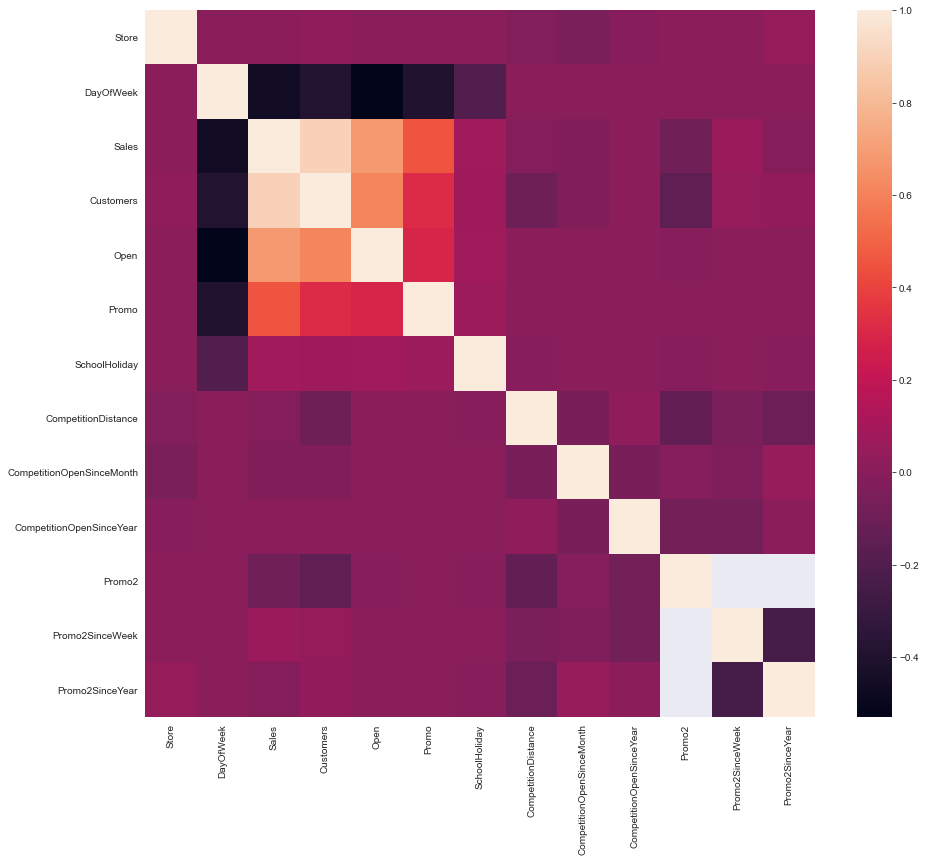

In [15]:
#drawing correlation matrix
corr = merged_df.corr()
plt.figure(figsize=(15,13))
sns.heatmap(corr)

Text(0.5, 1.0, 'Customers vs Sales')

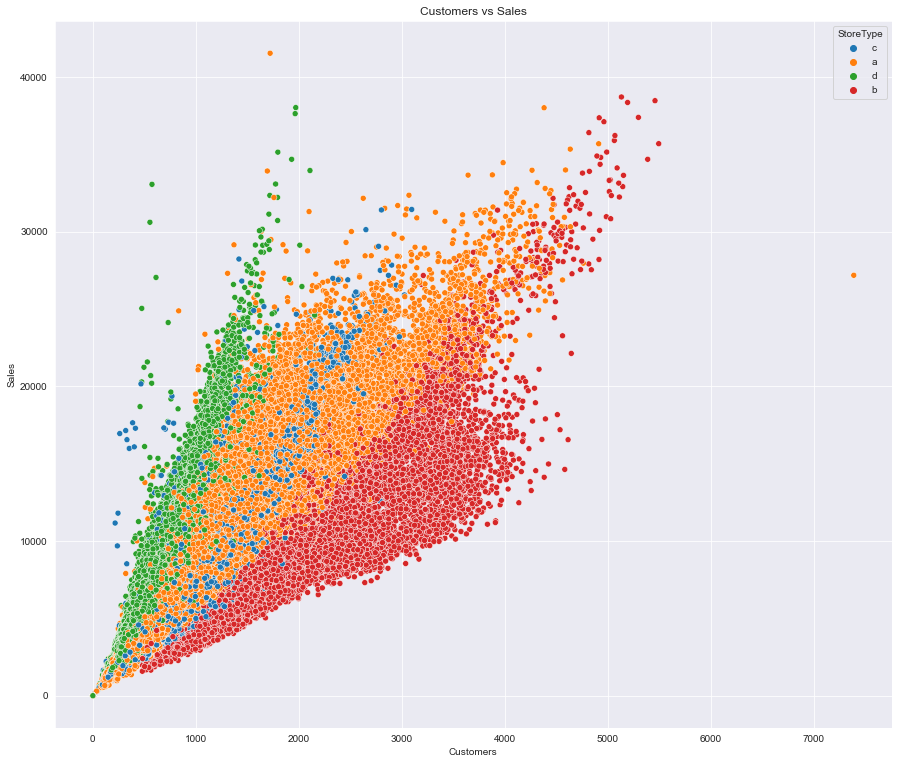

In [16]:
#plotting graph between Customers and Sales

plt.figure(figsize=(15,13))
sns.scatterplot(data=merged_df, x="Customers", y="Sales", hue = "StoreType").set_title('Customers vs Sales')

Text(0.5, 1.0, 'Customers in different Stores')

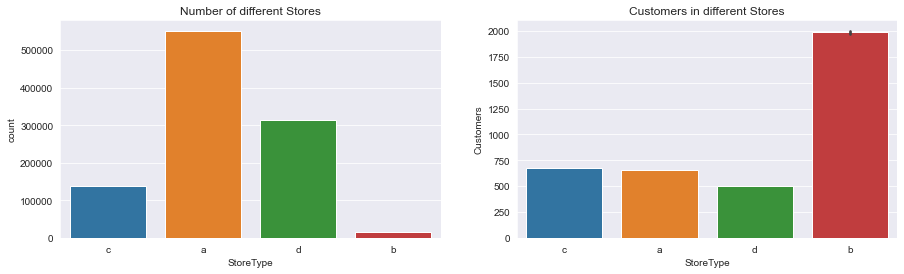

In [17]:
#drawing plots of StoreTypes and no of customers in different StoreTypes

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.countplot(x='StoreType', data=merged_df, ax=axis1).set_title('Number of different Stores')
sns.barplot(x='StoreType', y='Customers', data=merged_df, ax=axis2).set_title('Customers in different Stores')

Text(0.5, 1.0, 'Customers on different days')

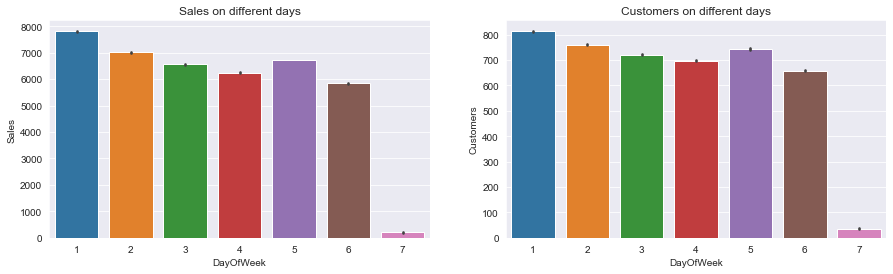

In [18]:
#drawing plots of DayOfWeek vs Sales and DayOfWeek vs Customers

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='DayOfWeek', y='Sales', data=merged_df, ax=axis1).set_title('Sales on different days')
sns.barplot(x='DayOfWeek', y='Customers', data=merged_df, ax=axis2).set_title('Customers on different days')

Text(0.5, 1.0, 'Effect of CompetitionDistance on Customers')

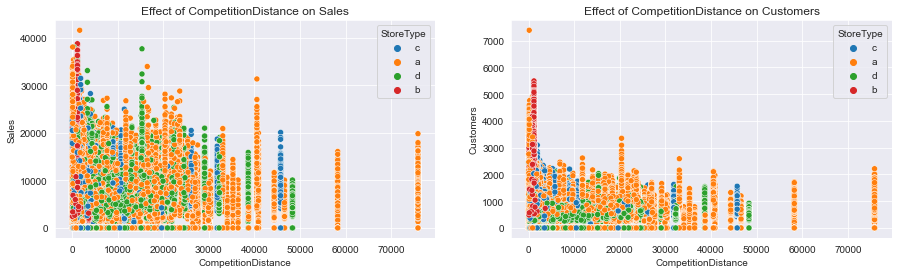

In [19]:
#drawing plots of CompetitionDistance vs Sales and CompetitionDistance vs Customers

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.scatterplot(x='CompetitionDistance', y='Sales', hue = "StoreType", data=merged_df, ax=axis1).set_title('Effect of CompetitionDistance on Sales')
sns.scatterplot(x='CompetitionDistance', y='Customers', hue = "StoreType", data=merged_df, ax=axis2).set_title('Effect of CompetitionDistance on Customers')

Text(0.5, 1.0, 'customers across different Promo2')

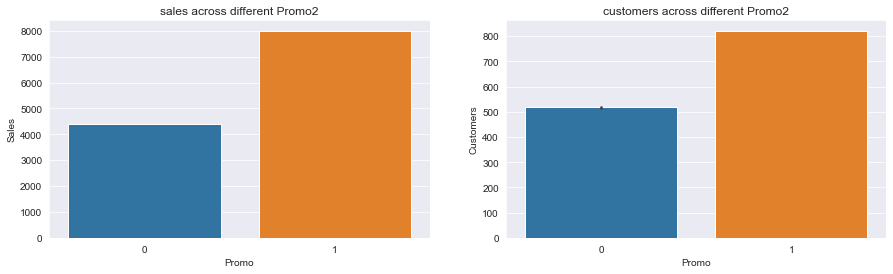

In [20]:
#drawing plots of Promo vs Sales and Promo vs Customers

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo', y='Sales', data=merged_df, ax=axis1).set_title('sales across different Promo2')
sns.barplot(x='Promo', y='Customers', data=merged_df, ax=axis2).set_title('customers across different Promo2')

Text(0.5, 1.0, 'customers across different Promo2')

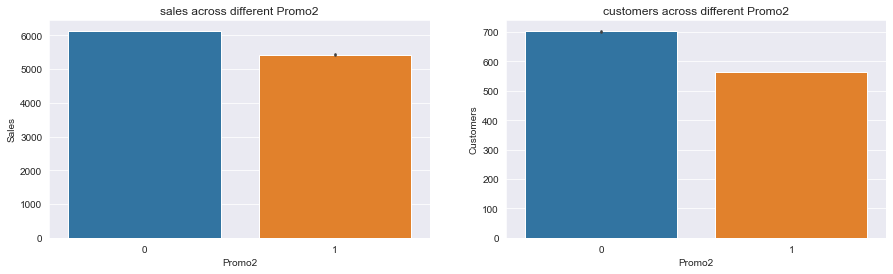

In [21]:
#drawing plots of Promo2 vs Sales and Promo2 vs Customers

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Promo2', y='Sales', data=merged_df, ax=axis1).set_title('sales across different Promo2')
sns.barplot(x='Promo2', y='Customers', data=merged_df, ax=axis2).set_title('customers across different Promo2')

**Observations:**

1. As expected, no of customers has direct relationship with Sales.
2. Even though there are less number of stres for StoreType B, it has been serving largest no of customers.
3. Storetype A has maximum no of stores however it does not serve that many customers.
4. Sales over the week is more or less same however we see a big spike in no of customers on Sundays.
5. As obvious, competition ditance has inverse impact on both Sales and Customers.
6. Store B has very less competition and that may be the reason of highest no of customers visiting Store B. CompetitionDistance 0 means there is no competition available.
7. Sales and No of Customers increases when any store runs a Promo on any day.

## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [22]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO


### Date

We can split date into Day, Year and Months and then it will make more sense of data. First, let's convert `Date` to a `datecolumn` and extract different parts of the date.

In [23]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [24]:
split_date(merged_df)
split_date(merged_test_df)

In [25]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


### Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [26]:
merged_df[merged_df.Open == 0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [27]:
merged_df = merged_df[merged_df.Open == 1].copy()

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

In [28]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [29]:
comp_months(merged_df)
comp_months(merged_test_df)

In [30]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1,76.0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1,159.0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0


Let's view the results of the new columns we've created.

In [31]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
999443,2013-01-16,330.0,NaN,NaN,0.0
326474,2014-09-26,130.0,NaN,NaN,0.0
428675,2014-06-12,290.0,2011.0,10.0,32.0
259825,2014-12-06,11810.0,2014.0,8.0,4.0
529481,2014-03-14,530.0,2005.0,4.0,107.0
407907,2014-07-01,820.0,NaN,NaN,0.0
638580,2013-12-06,5300.0,NaN,NaN,0.0
204511,2015-01-29,20390.0,2008.0,4.0,81.0
781571,2013-07-31,4380.0,NaN,NaN,0.0
875668,2013-05-07,22560.0,NaN,NaN,0.0


### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [32]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [33]:
promo_cols(merged_df)
promo_cols(merged_test_df)

Let's view the results of the columns we've created.

In [34]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
656146,2013-11-20,0,NaN,NaN,NaN,0.000000,0
772783,2013-08-08,0,NaN,NaN,NaN,0.000000,0
649002,2013-11-27,1,2014.0,40.0,"Jan,Apr,Jul,Oct",0.000000,0
340023,2014-09-12,1,2011.0,40.0,"Jan,Apr,Jul,Oct",35.311475,0
483808,2014-04-24,1,2012.0,22.0,"Jan,Apr,Jul,Oct",22.852459,1
462661,2014-05-13,0,NaN,NaN,NaN,0.000000,0
994519,2013-01-21,0,NaN,NaN,NaN,0.000000,0
1001460,2013-01-15,0,NaN,NaN,NaN,0.000000,0
670523,2013-11-07,0,NaN,NaN,NaN,0.000000,0
663743,2013-11-14,1,2011.0,14.0,"Jan,Apr,Jul,Oct",31.344262,0


The features related to competition and promotion are now much more useful.

### Input and Target Columns

Let's select the columns that we'll use for training.

In [35]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [36]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [37]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [38]:
test_inputs = merged_test_df[input_cols].copy()

Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [39]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Impute missing numerical data

In [40]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [41]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

In [42]:
max_distance = inputs.CompetitionDistance.max()

In [43]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [45]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [46]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [47]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [48]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [49]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

We haven't created a validation set yet, because we'll use K-fold cross validation.

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions for the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 

### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [50]:
from xgboost import XGBRegressor

In [51]:
?XGBRegressor

In [52]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

Let's train the model using `model.fit`.

In [53]:
%%time
model.fit(X, targets)

Wall time: 6.71 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [54]:
preds = model.predict(X)

In [55]:
preds

array([ 8127.9404,  7606.919 ,  8525.857 , ...,  6412.8247,  9460.068 ,
       10302.145 ], dtype=float32)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [56]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [57]:
rmse(preds, targets)

2377.752008804669

### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [58]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

In [59]:
#plot_tree(model, rankdir='LR');

In [60]:
#plot_tree(model, rankdir='LR', num_trees=1);

In [61]:
#plot_tree(model, rankdir='LR', num_trees=19);

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [62]:
trees = model.get_booster().get_dump()

In [63]:
len(trees)

20

In [64]:
print(trees[0])

0:[Promo<0.5] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<0.00441719405] yes=15,no=16,missing=15
				15:leaf=2309.51147
				16:leaf=1823.30444
			8:[WeekOfYear<0.911764741] yes=17,no=18,missing=17
				17:leaf=1619.43994
				18:leaf=2002.44897
		4:[CompetitionDistance<0.01602057] yes=9,no=10,missing=9
			9:[CompetitionDistance<0.0134493671] yes=19,no=20,missing=19
				19:leaf=2740.44067
				20:leaf=5576.85889
			10:[DayOfWeek_7<0.5] yes=21,no=22,missing=21
				21:leaf=1898.36487
				22:leaf=2961.08765
	2:[DayOfWeek_1<0.5] yes=5,no=6,missing=5
		5:[Month<0.954545498] yes=11,no=12,missing=11
			11:[StoreType_b<0.5] yes=23,no=24,missing=23
				23:leaf=2295.30566
				24:leaf=3294.27759
			12:[Day<0.333333343] yes=25,no=26,missing=25
				25:leaf=2754.58521
				26:leaf=3246.39014
		6:[Month<0.954545498] yes=13,no=14,missing=13
			13:[CompetitionDistance<0.002703059] yes=27,no=28,missing=27
				27:leaf=334

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [65]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [66]:
importance_df.head(10)

,feature,importance
1,Promo,0.317473
24,StoreType_b,0.086472
12,DayOfWeek_1,0.082269
5,Promo2,0.063986
3,CompetitionDistance,0.045053
29,Assortment_c,0.040226
27,Assortment_a,0.038759
9,Month,0.038493
0,Store,0.038119
8,Day,0.033209


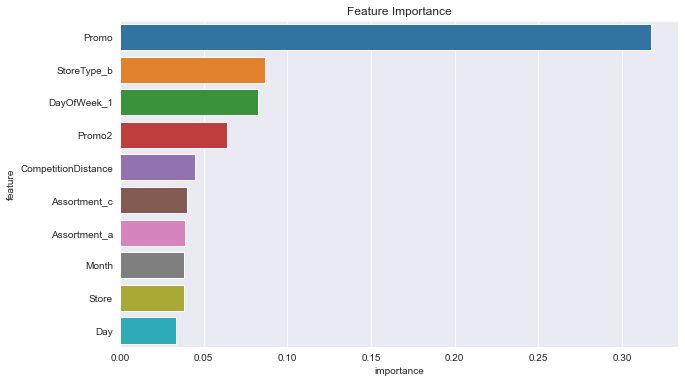

In [67]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Let's save our work before continuing.

In [68]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "kashyap-shubham11/python-gradient-boosting-machines-d0caf" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/kashyap-shubham11/python-gradient-boosting-machines-d0caf


'https://jovian.ai/kashyap-shubham11/python-gradient-boosting-machines-d0caf'

## K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

Scikit-learn provides utilities for performing K fold cross validation.

In [69]:
from sklearn.model_selection import KFold

Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.

In [70]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

In [71]:
kfold = KFold(n_splits=5)

In [72]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2352.216448531526, Validation RMSE: 2424.6228916973314
Train RMSE: 2406.709513789309, Validation RMSE: 2451.9646038059277
Train RMSE: 2365.7354745443067, Validation RMSE: 2336.984157073758
Train RMSE: 2366.4732092777763, Validation RMSE: 2460.8995475901697
Train RMSE: 2379.3752997474626, Validation RMSE: 2440.665320626728


Let's also define a function to average predictions from the 5 different models.

In [73]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [74]:
preds = predict_avg(models, X)

In [75]:
preds

array([8021.374 , 7577.715 , 8747.863 , ..., 7615.0303, 7924.784 ,
       9600.297 ], dtype=float32)

We can now use `predict_avg` to make predictions for the test set.

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

In [76]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [77]:
?XGBRegressor

Here's a helper function to test hyperparameters with K-fold cross validation.

In [78]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set.

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [81]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Max Depth: {}, Learning Rate: {}, Train RMSE: {}, Validation RMSE: {}'.format(model.max_depth, model.learning_rate, train_rmse, val_rmse))
    return {'Learning Rate': model.learning_rate, 'Max Depth': model.max_depth, 'Training Error': train_rmse, 'Validation Error': val_rmse}

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model. We will take a value of 1000.


#### `max_depth`

As we increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

> Lets experiment with different values of `max_depth`, plot a graph of the training and validation error and determine the optimal.

In [84]:
%%time
errors_df_max_depth = pd.DataFrame([test_params(max_depth = md, n_estimators=200) for md in range(8, 18)])


Max Depth: 8, Learning Rate: None, Train RMSE: 723.7579764837932, Validation RMSE: 796.4236140121292
Max Depth: 9, Learning Rate: None, Train RMSE: 641.2796923399426, Validation RMSE: 753.8636912622156
Max Depth: 10, Learning Rate: None, Train RMSE: 565.6343269406765, Validation RMSE: 734.4460692926741
Max Depth: 11, Learning Rate: None, Train RMSE: 494.0583279783455, Validation RMSE: 718.881264150255
Max Depth: 12, Learning Rate: None, Train RMSE: 408.4829678920262, Validation RMSE: 727.103269235848
Max Depth: 13, Learning Rate: None, Train RMSE: 341.2774750372153, Validation RMSE: 728.5645808104307
Max Depth: 14, Learning Rate: None, Train RMSE: 267.2365006466406, Validation RMSE: 745.7015851870616
Max Depth: 15, Learning Rate: None, Train RMSE: 193.2013450218246, Validation RMSE: 772.0681814169205
Max Depth: 16, Learning Rate: None, Train RMSE: 134.1819269373581, Validation RMSE: 779.8855234765108
Max Depth: 17, Learning Rate: None, Train RMSE: 78.92247019366928, Validation RMSE: 80

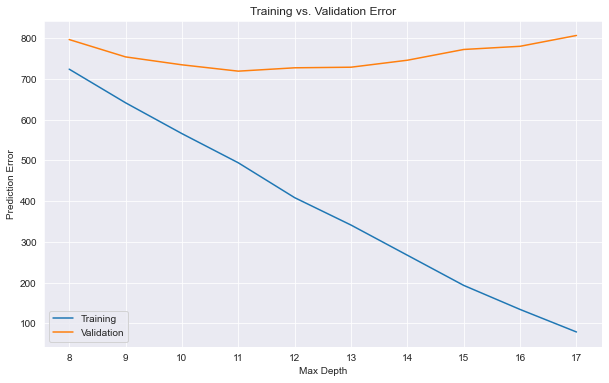

In [85]:
plt.figure(figsize=(10,6))
plt.plot(errors_df_max_depth['Max Depth'], errors_df_max_depth['Training Error'])
plt.plot(errors_df_max_depth['Max Depth'], errors_df_max_depth['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(8,18))
plt.xlabel('Max Depth')
plt.ylabel('Prediction Error')
plt.legend(['Training', 'Validation'])

#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

> Lets experiment with different values of `learning_rate`, plot a graph of the training and validation error and determine the optimal.

In [86]:
%%time
errors_df_learning_rate = pd.DataFrame([test_params(n_estimators=200, max_depth = 11, learning_rate = lr) for lr in np.linspace(0.1, 0.8, num=50)])

Max Depth: 11, Learning Rate: 0.1, Train RMSE: 684.5363180259766, Validation RMSE: 801.9463729014589
Max Depth: 11, Learning Rate: 0.1142857142857143, Train RMSE: 662.0313866056393, Validation RMSE: 787.2167642580445
Max Depth: 11, Learning Rate: 0.1285714285714286, Train RMSE: 616.8956055207742, Validation RMSE: 754.3759845105319
Max Depth: 11, Learning Rate: 0.14285714285714285, Train RMSE: 603.6812782030408, Validation RMSE: 747.1000103352878
Max Depth: 11, Learning Rate: 0.15714285714285714, Train RMSE: 584.3542640760645, Validation RMSE: 743.427562483301
Max Depth: 11, Learning Rate: 0.17142857142857143, Train RMSE: 575.760378789745, Validation RMSE: 735.0392536922334
Max Depth: 11, Learning Rate: 0.18571428571428572, Train RMSE: 553.1746674191392, Validation RMSE: 727.2903907702843
Max Depth: 11, Learning Rate: 0.2, Train RMSE: 549.6321214297898, Validation RMSE: 724.7652980049972
Max Depth: 11, Learning Rate: 0.2142857142857143, Train RMSE: 539.4259025388454, Validation RMSE: 72

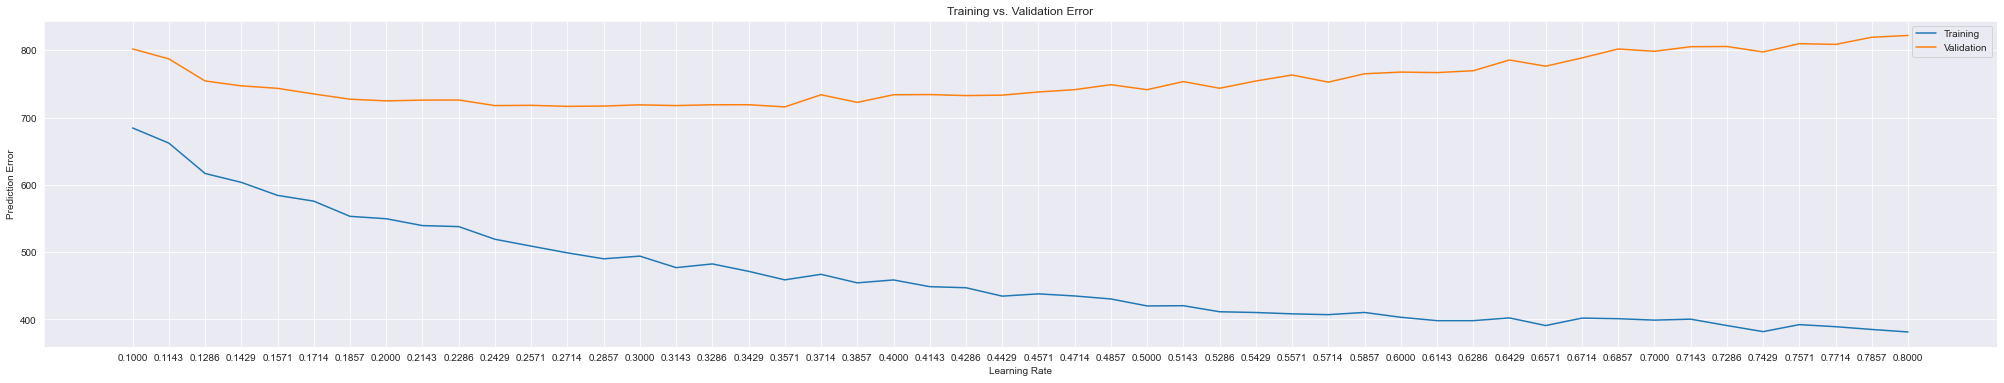

In [87]:
plt.figure(figsize=(35,6))
plt.plot(errors_df_learning_rate['Learning Rate'], errors_df_learning_rate['Training Error'])
plt.plot(errors_df_learning_rate['Learning Rate'], errors_df_learning_rate['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(np.linspace(0.1, 0.8, num=50))
plt.xlabel('Learning Rate')
plt.ylabel('Prediction Error')
plt.legend(['Training', 'Validation'])

**Observations:**
- We see optimal value can be picked at `max_depth` = 11.
- Lets take no of estimators = 200 on a safe side.
- The optimal value for `learning_rate` can be taken as 0.3571

> Lets calculate the errors by putting all parameters together.

In [88]:
test_params(n_estimators=1000, max_depth = 11, learning_rate = 0.2571)

Max Depth: 11, Learning Rate: 0.2571, Train RMSE: 242.65775159766082, Validation RMSE: 683.4386818116732


{'Learning Rate': 0.2571,
 'Max Depth': 11,
 'Training Error': 242.65775159766082,
 'Validation Error': 683.4386818116732}

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [89]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2571, max_depth=11, subsample=0.9, 
                     colsample_bytree=0.7)

In [90]:
%%time
model.fit(X, targets)

Wall time: 15min 31s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2571, max_delta_step=0, max_depth=11,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

Now that the model is trained, we can make predictions on the test set.

In [91]:
test_preds = model.predict(X_test)

Let's add the predictions into `submission_df`.

In [92]:
submission_df['Sales']  = test_preds

Recall, however, if if the store is not open, then the sales must be 0. Thus, wherever the value of `Open` in the test set is 0, we can set the sales to 0. Also, there some missing values for `Open` in the test set. We'll replace them with 1 (open).

In [93]:
test_df.Open.isna().sum()

11

In [94]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)

In [95]:
submission_df

,Id,Sales
0,1,4457.364746
1,2,7752.540039
2,3,9132.433594
3,4,7532.203613
4,5,6820.651855
...,...,...
41083,41084,4257.973633
41084,41085,7166.009277
41085,41086,5563.672852
41086,41087,20210.105469


We can now save the predictions as a CSV file.

In [96]:
submission_df.to_csv('submission.csv', index=None)

In [97]:
submission_df

,Id,Sales
0,1,4457.364746
1,2,7752.540039
2,3,9132.433594
3,4,7532.203613
4,5,6820.651855
...,...,...
41083,41084,4257.973633
41084,41085,7166.009277
41085,41086,5563.672852
41086,41087,20210.105469


In [98]:
from IPython.display import FileLink

In [99]:
# Doesn't work on Colab, use the file browser instead.
FileLink('submission.csv')

C:\Users\kashy\OneDrive\Desktop\Data Scientist\my projects\xg boost\python-gradient-boosting-machines-v-2\submission.csv